In [3]:
import warnings
warnings.filterwarnings('ignore') # 把一些惱人的警示訊息暫時忽略

import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
import keras.utils as np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from matplotlib import pyplot as plt

from pathlib import PurePath # 處理不同作業系統file path的解析問題 (*nix vs windows)

%matplotlib inline

NUM_CLASSES = 43 # 共有43種要辨識的交通標誌
IMG_SIZE = 48 # 每張圖像最後都要整理成 48x48的大小

In [4]:
# 圖像標高度均衡、置中及大小調整
def preprocess_img(img):
    # 進行"直方圖均衡化"處理
    hsv = color.rgb2hsv(img) # 對彩色分量rgb分別做均衡化，會產生奇異的點，圖像不和諧。一般採用的是用hsv空間進行亮度的均衡
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv) # 再把圖像從hsv轉回rgb
    
    # 進行圖像置中
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    
    # 改變大小
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))    
    return img

# 取得圖像檔的分類標籤
def get_class(img_path):
    # 圖像檔所在的檔案夾名稱就是該圖像檔的分類標籤
    return int(PurePath(img_path).parts[-2])

In [5]:
# 從檔案系統中把保留的資料載入(如果沒有就進行第一次的資料轉換處理)
try:
    with h5py.File('X.h5') as hf:
        X, Y = hf['imgs'][:], hf['labels'][:]
    
    print("Loaded images from X.h5")
    
except(IOError, OSError, KeyError):
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'GTSRB/Final_Training/Images/'
    imgs = []
    labels = []
    
    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm')) # 我們有 Test與Traing兩個檔案夾的資料要處理
    np.random.shuffle(all_img_paths) # 進行打散
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img) # 保留圖像資料
            labels.append(label) # 保留圖像標籤
            
            if len(imgs)%1000 == 0:
                print("Processed {}/{}".format(len(imgs), len(all_img_paths))) # 每1000筆秀一下進度
        except(IOError, OSError):
            print('missed', img_path)
            pass
        
    X = np.array(imgs, dtype='float32') # 將資料轉換成numpy的ndarray, 資料型別為float32
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] # 對labels的資料進行one-hot (使用numpy.eye的函式)
    
    # 將處理過圖像資料與標籤保持在檔案系統, 下次可以加速載入與處理
    with h5py.File('X.h5', 'w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Error in reading X.h5. Processing all images...
Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209


In [6]:
# 產生一個Keras序貫模型
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model;   

model = cnn_model() # 初始化一個模型
model.summary() # 秀出模型架構

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0

In [7]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.005
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [11]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 40
nb_epoch = 30

history = model.fit(X, Y,
         batch_size=batch_size,
         epochs=nb_epoch,
         validation_split=0.2,
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])

Epoch 1/30
785/785 [==============================] - 34s 44ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 2/30
785/785 [==============================] - 35s 45ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0230 - val_accuracy: 0.9934
Epoch 3/30
785/785 [==============================] - 34s 44ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0246 - val_accuracy: 0.9927
Epoch 4/30
785/785 [==============================] - 35s 45ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0231 - val_accuracy: 0.9948
Epoch 5/30
785/785 [==============================] - 35s 45ms/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.0190 - val_accuracy: 0.9952
Epoch 6/30
785/785 [==============================] - 39s 50ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0182 - val_accuracy: 0.9955
Epoch 7/30
785/785 [==============================] - 39s 49ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0248 - val_accuracy:

In [13]:
history

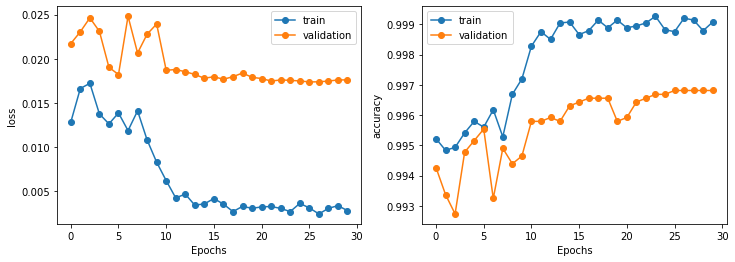

In [14]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'accuracy','val_accuracy')

plt.show()

In [18]:
import pandas as pd


test = pd.read_csv('GTSRB/GT-final_test.csv', sep=';')
# 裡面包含了六個欄位 Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId

X_test = []
y_test = []

# 迭代處理每一筆要測試的圖像檔
i=0
for file_name, class_id in zip(list(test['Filename']),list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
# 轉換成numpy ndarray
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_test.shape:  (12630, 48, 48, 3)
y_test.shape:  (12630,)


In [19]:
# 預測與比對
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9693586698337292


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            rotation_range=10.,
                            width_shift_range=0.1,
                            height_shift_range=0.1,                             
                            shear_range=0.1,
                            zoom_range=0.2,
                            )

datagen.fit(X_train)

In [21]:
# 重新重置一個新的模型
model = cnn_model()

# 讓我們用相同的組合
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
nb_epoch = 30

# 透過data generator來產生訓練資料, 由於資料是可持續產生, 我們可以透過設定'steps_per_epoch'的數量來讓模型可以有更多的訓練批次
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0]/batch_size,
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model2.h5',save_best_only=True)]
                           )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
981/980 [==============================] - 63s 64ms/step - loss: 2.4210 - accuracy: 0.2970 - val_loss: 1.1604 - val_accuracy: 0.5863
Epoch 2/30
981/980 [==============================] - 65s 67ms/step - loss: 0.9119 - accuracy: 0.7045 - val_loss: 0.2343 - val_accuracy: 0.9188
Epoch 3/30
981/980 [==============================] - 70s 72ms/step - loss: 0.3823 - accuracy: 0.8798 - val_loss: 0.0705 - val_accuracy: 0.9781
Epoch 4/30
981/980 [==============================] - 64s 65ms/step - loss: 0.2440 - accuracy: 0.9224 - val_loss: 0.0346 - val_accuracy: 0.9898
Epoch 5/30
981/980 [==============================] - 63s 64ms/step - loss: 0.1850 - accuracy: 0.9435 - val_loss: 0.0352 - val_accuracy: 0.9895
Epoch 6/30
981/980 [==============================] - 69s 70ms/step - loss: 0.1697 - accuracy: 0.9488 - val_loss: 0.0267 - val_accuracy: 0.9931
Epoch 7/30
981/980 [==============================] - 54s 55

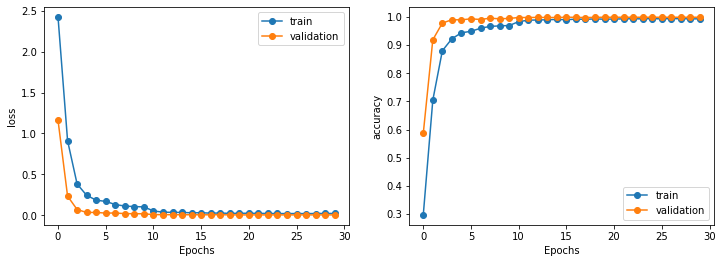

In [23]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'accuracy','val_accuracy')

plt.show()

In [27]:
ListNode